# Imports

In [203]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pandas as pd

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, confusion_matrix

PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
EMG_DIR = os.path.join(DATA_DIR, "EMG")
OUT_DIR = os.path.join(PROJECT_ROOT, "output")

EMG_OUTPUT_DIR = os.path.join(OUT_DIR, "emg")
os.makedirs(EMG_OUTPUT_DIR, exist_ok=True)

np.random.seed(42)

# Part 1: Single subject classification

## Loading data

In [205]:
def load_and_save_raw_data(subject_id='s2', base_dir='data/emg', output_dir='data/output'):
    s2_dir = Path(base_dir) / subject_id
    output_s2_dir = Path(output_dir) / subject_id
    os.makedirs(output_s2_dir, exist_ok=True)

    # 1. Locate the .mat file
    ex1_file = sorted(s2_dir.glob(f'{subject_id.upper()}_A1_E1.mat'))
    
    if not ex1_file:
        # Fallback check for different casing if necessary, or just raise error
        # Assuming standard Ninapro naming like S2_A1_E1.mat
        raise FileNotFoundError(f'{subject_id.upper()}_A1_E1.mat not found under {s2_dir}')
    
    ex1_path = ex1_file[0]
    print(f"Loading raw file: {ex1_path.name}")
    
    mat_ex1 = loadmat(ex1_path, squeeze_me=True)

    # 2. Extract Fields safely
    subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
    exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
    stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
    restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
    repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
    rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
    emg_ex1 = np.asarray(mat_ex1['emg'])
    glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
    
    # Handle fs (sampling frequency)
    fs_val = mat_ex1.get('fs', None)
    fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0

    # 3. Save to .npz
    out_path = output_s2_dir / f'{subject_id}_ex1_raw.npz'
    np.savez(
        out_path,
        subject=subject,
        exercise=exercise,
        stimulus=stimulus,
        restimulus=restimulus,
        repetition=repetition,
        rerepetition=rerepetition,
        emg=emg_ex1,
        glove=glove,
        fs=fs_ex1,
    )
    print(f'Saved raw data to {out_path}')
    return out_path

In [207]:
s2_dir = Path(EMG_DIR) / 's2'

mat_files = sorted(s2_dir.glob('S2_*.mat'))
print(f'found {len(mat_files)} .mat files for subject 2')
for f in mat_files:
    m = loadmat(f, squeeze_me=True)
    keys = [k for k in m.keys() if not k.startswith('__')]
    print(f'\n{f.name}: keys -> {keys}')
    emg_key = next((k for k in keys if 'emg' in k.lower()), None)
    if emg_key:
        emg = m[emg_key]
        print(f'  {emg_key} shape: {np.shape(emg)}')
    restimulus = m.get('restimulus', None)
    if restimulus is not None:
        rs = np.asarray(restimulus).ravel()
        print(f'  unique stimulus labels: {np.unique(rs)}')
    rerepetition = m.get('rerepetition', None)
    if rerepetition is not None:
        rr = np.asarray(rerepetition).ravel()
        print(f'  repetitions: {np.unique(rr)}')

load_and_save_raw_data(subject_id='s2', base_dir=EMG_DIR, output_dir=EMG_DIR)

found 3 .mat files for subject 2

S2_A1_E1.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (100686, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E2.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (142731, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E3.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (229084, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]
Loading raw file: S2_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz


PosixPath('/Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz')

### Visualize data before processing

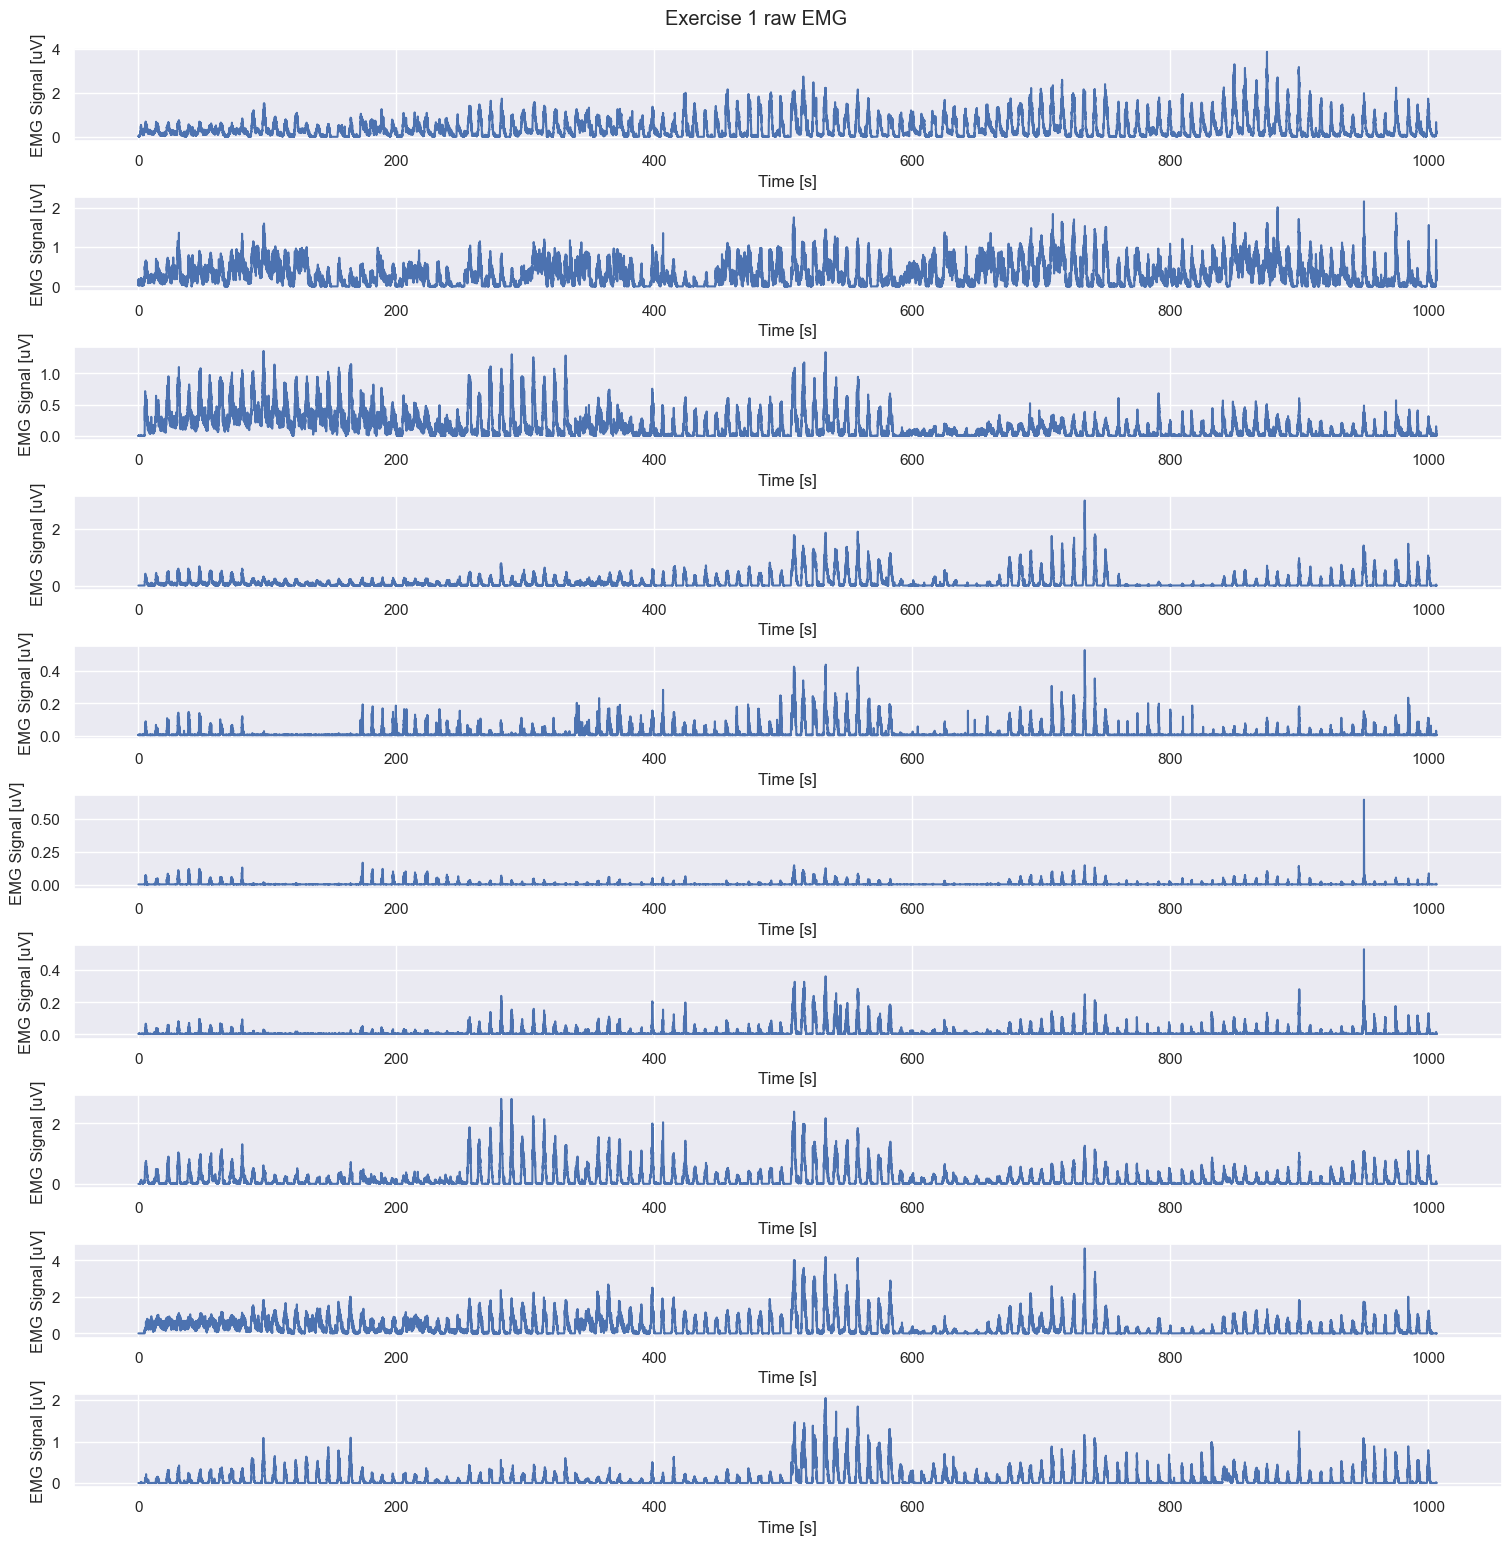

In [209]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg_raw = raw['emg']
fs = float(raw['fs'])
n_channels = emg_raw.shape[1]
time_steps = np.arange(emg_raw.shape[0]) / fs

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


## Preprocessing

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

In [210]:
def preprocess_emg_data(raw_npz_path, output_dir='data/output'):
    raw_npz_path = Path(raw_npz_path)
    if not raw_npz_path.exists():
        raise FileNotFoundError(f"{raw_npz_path} not found.")

    raw = np.load(raw_npz_path, allow_pickle=True)
    emg = raw['emg']
    fs = float(raw['fs'])
    
    # apply filter (1Hz Low Pass for Envelope)
    sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
    emg_filtered = sosfiltfilt(sos, emg.T).T

    filename_parts = raw_npz_path.stem.split('_')
    subject_id = filename_parts[0] if len(filename_parts) > 0 else 'unknown'
    
    out_dir_full = Path(output_dir) / subject_id
    os.makedirs(out_dir_full, exist_ok=True)
    band_out = out_dir_full / f'{subject_id}_ex1_processed.npz'

    # 3. Save
    np.savez(
        band_out,
        emg=emg_filtered,
        subject=raw.get('subject'),
        exercise=raw.get('exercise'),
        stimulus=raw.get('stimulus'),
        restimulus=raw.get('restimulus'),
        repetition=raw.get('repetition'),
        rerepetition=raw.get('rerepetition'),
        glove=raw.get('glove'),
        fs=fs,
    )
    print(f'Processed (Filtered) data saved to {band_out}')
    return band_out

Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz


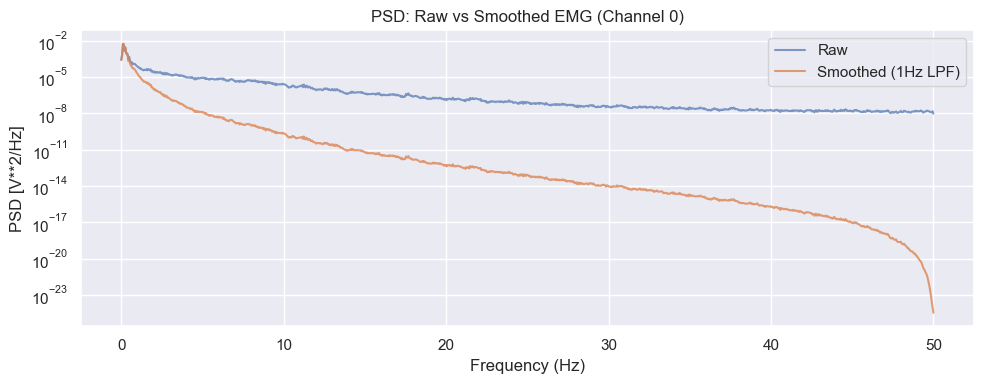

In [217]:
raw_npz_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
processed_path = preprocess_emg_data(raw_npz_path, output_dir=EMG_OUTPUT_DIR)

raw = np.load(raw_npz_path)
proc = np.load(processed_path)
emg_raw = raw['emg']
emg_smooth = proc['emg']
fs = float(raw['fs'])

channel_idx = 4

f_raw, psd_raw = welch(emg_raw[:, channel_idx], fs=fs, nperseg=2048)
f_smooth, psd_smooth = welch(emg_smooth[:, channel_idx], fs=fs, nperseg=2048)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, psd_raw, label='Raw', alpha=0.7)
plt.semilogy(f_smooth, psd_smooth, label='Smoothed (1Hz LPF)', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD: Raw vs Smoothed EMG (Channel 0)')
plt.legend()
plt.tight_layout()
plt.show()


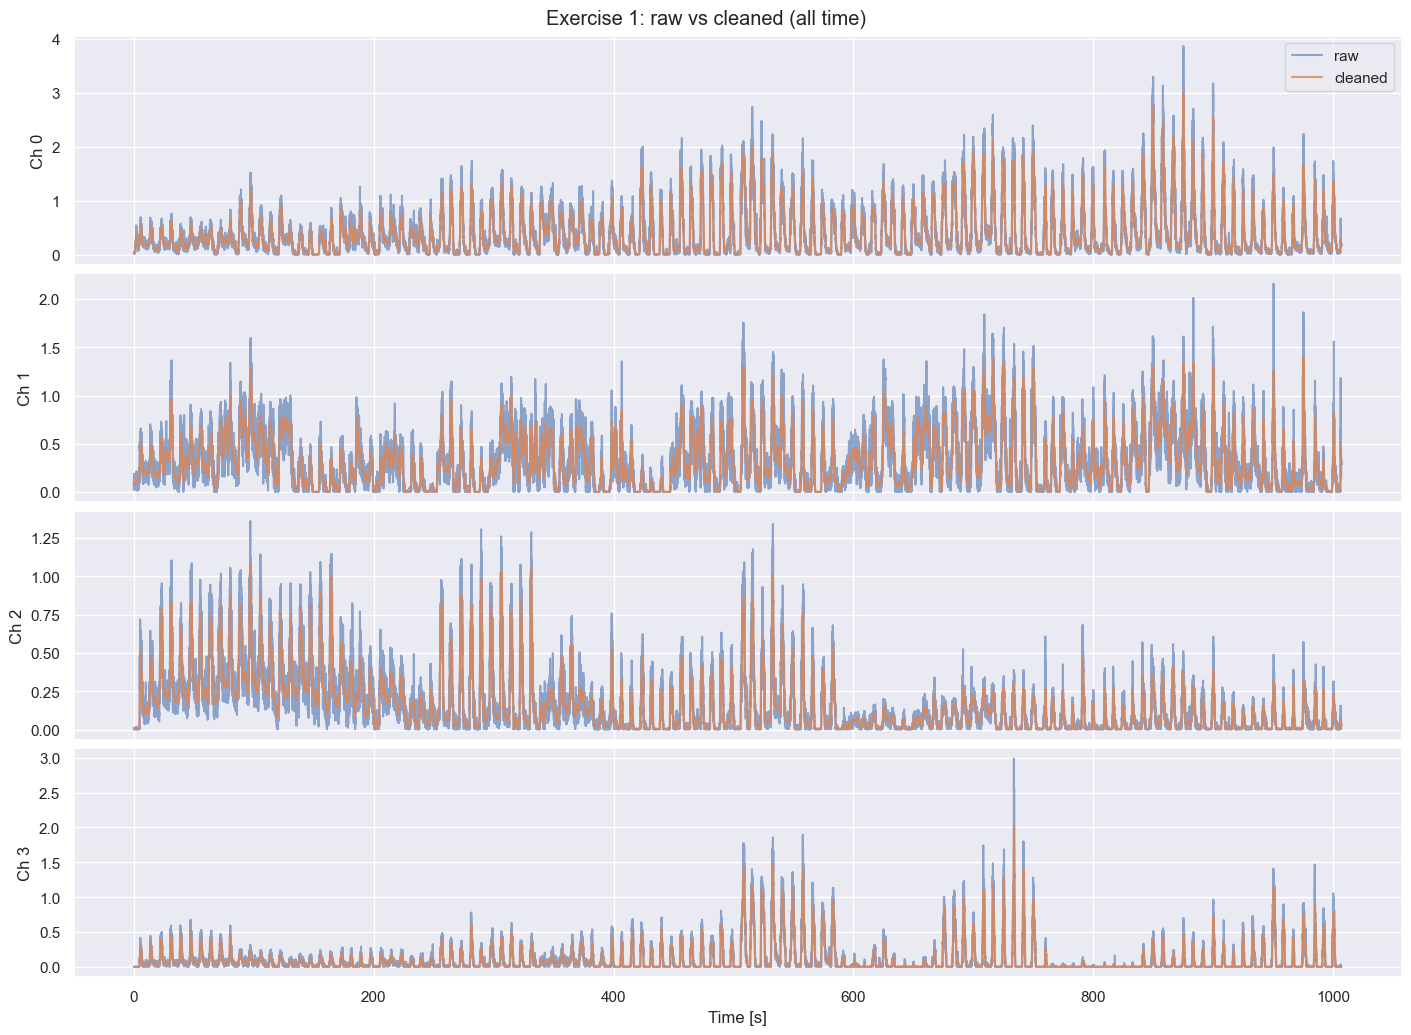

In [108]:
# Overlay raw vs cleaned (all time, first 4 channels)
raw_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
proc_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
raw = np.load(raw_path)
proc = np.load(proc_path)
emg_raw = raw['emg']
emg_clean = proc['emg']
fs = float(raw['fs'])
span = emg_raw.shape[0]  # Plot all samples
channels_to_plot = min(4, emg_raw.shape[1])
t = np.arange(span) / fs

fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)
    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()


### Inspecting bad trials

In [241]:
def clean_and_filter_trials(processed_npz_path, output_dir='data/output'):
    processed_npz_path = Path(processed_npz_path)
    if not processed_npz_path.exists():
        print(f"Error: File not found at {processed_npz_path}")
        return None

    print(f"Filtering bad trials from {processed_npz_path}")

    data = np.load(processed_npz_path, allow_pickle=True)
    emg = data['emg']
    restimulus = data['restimulus']   
    rerepetition = data['rerepetition']
    fs = data['fs']
    
    DEAD_THRESHOLD = 1e-6    
    ARTIFACT_THRESHOLD = 5.0 

    bad_trials_indices = []    
    movements = np.unique(restimulus)
    movements = movements[movements != 0] # active movements only

    for mov in movements:
        for rep in range(1, 11): 
            mask_indices = np.where((restimulus == mov) & (rerepetition == rep))[0]
            
            if len(mask_indices) == 0:
                continue
            
            trial_data = emg[mask_indices]
            
            is_artifact = np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD
            
            channel_stds = np.std(trial_data, axis=0)
            is_dead_channel = np.any(channel_stds < DEAD_THRESHOLD)
            
            if is_dead_channel or is_artifact:
                reason = "Artifact" if is_artifact else "Dead Channel(s): "
                
                if is_dead_channel:
                    dead_ch_idx = np.where(channel_stds < DEAD_THRESHOLD)[0]
                    reason += f" {dead_ch_idx + 1}"
                
                print(f"  Discarding Bad Trial: Mov {mov}, Rep {rep} [{reason}]")
                bad_trials_indices.extend(mask_indices)

    keep_mask = (restimulus != 0)
    if len(bad_trials_indices) > 0:
        keep_mask[bad_trials_indices] = False

    emg_final = emg[keep_mask]
    restimulus_final = restimulus[keep_mask]
    rerepetition_final = rerepetition[keep_mask]

    print(f"Original shape: {emg.shape}")
    print(f"Final shape:    {emg_final.shape} (Rest & Bad Trials removed)")

    filename_parts = processed_npz_path.stem.split('_')
    subject_id = filename_parts[0]
    out_dir_full = Path(output_dir) / subject_id
    output_path = out_dir_full / f'{subject_id}_ex1_cleaned.npz'

    np.savez(output_path, 
             emg=emg_final, 
             restimulus=restimulus_final, 
             rerepetition=rerepetition_final, 
             fs=fs)

    print(f"Cleaned data saved to: {output_path}")
    print("-" * 30)
    return output_path

In [234]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
clean_and_filter_trials(input_path, output_dir=EMG_OUTPUT_DIR)

Filtering bad trials from /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Cleaned data saved to: /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_cleaned.npz
------------------------------


PosixPath('/Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_cleaned.npz')

### Visualizing average activation maps

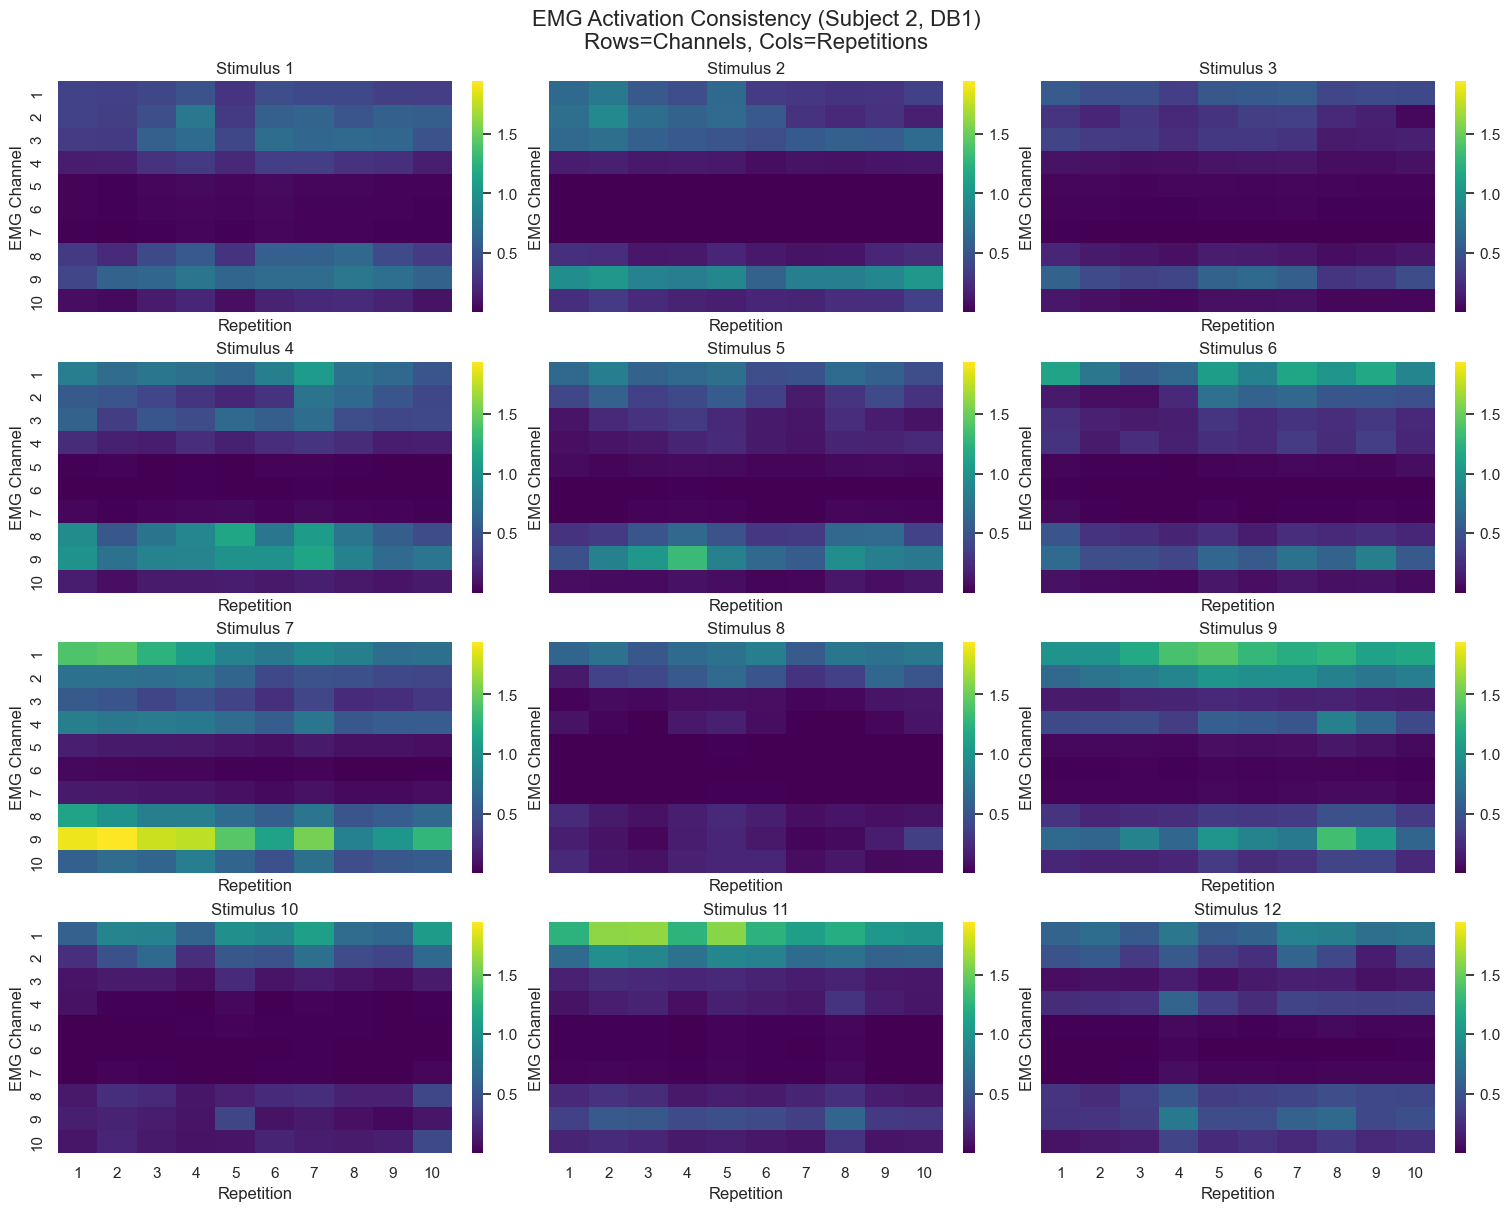

In [235]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'

data = np.load(input_path)
emg = data['emg']
stimulus = data['restimulus']
repetition = data['rerepetition']
fs = float(data['fs'])

unique_movs = np.unique(stimulus)
unique_reps = np.unique(repetition)

n_channels = emg.shape[1]
n_stimuli = len(unique_movs)
n_repetitions = len(unique_reps)

activation_matrix = np.full((n_channels, n_stimuli, n_repetitions), np.nan)

for mov_idx, mov_label in enumerate(unique_movs):
    for rep_idx, rep_label in enumerate(unique_reps):
        mask = (stimulus == mov_label) & (repetition == rep_label)
        trial_data = emg[mask]
        
        if len(trial_data) > 0:
            activation_matrix[:, mov_idx, rep_idx] = np.mean(trial_data, axis=0)

fig, ax = plt.subplots(4, 3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

vmin = np.nanmin(activation_matrix)
vmax = np.nanmax(activation_matrix)

for stimuli_idx in range(n_stimuli):
    data_for_plot = activation_matrix[:, stimuli_idx, :]
    
    sns.heatmap(data_for_plot, ax=ax[stimuli_idx], 
                xticklabels=np.arange(1, 11), 
                yticklabels=np.arange(1, 11), 
                cbar=True, cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax[stimuli_idx].set_title(f"Stimulus {unique_movs[stimuli_idx]}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG Channel")

plt.suptitle(f"EMG Activation Consistency (Subject 2, DB1)\nRows=Channels, Cols=Repetitions", fontsize=16)
plt.show()

## Preparing datasets (split)

In [243]:
def split_data_by_repetition(cleaned_npz_path, output_dir='data/output'):
    cleaned_npz_path = Path(cleaned_npz_path)
    if not cleaned_npz_path.exists():
        raise FileNotFoundError(f"{cleaned_npz_path} not found.")

    data = np.load(cleaned_npz_path, allow_pickle=True)
    X = data['emg']
    y = data['restimulus']
    rep = data['rerepetition']
    fs = float(data['fs'])

    train_reps = [1, 3, 4, 6, 8, 9]
    val_reps   = [2, 5]
    test_reps  = [7, 10]

    mask_train = np.isin(rep, train_reps)
    mask_val   = np.isin(rep, val_reps)
    mask_test  = np.isin(rep, test_reps)

    X_train, y_train, rep_train = X[mask_train], y[mask_train], rep[mask_train]
    X_val,   y_val,   rep_val   = X[mask_val],   y[mask_val],   rep[mask_val]
    X_test,  y_test,  rep_test  = X[mask_test],  y[mask_test],  rep[mask_test]

    print(f"Train samples: {len(X_train)} (Reps {train_reps})")
    print(f"Val samples:   {len(X_val)}   (Reps {val_reps})")
    print(f"Test samples:  {len(X_test)}  (Reps {test_reps})")

    filename_parts = cleaned_npz_path.stem.split('_')
    subject_id = filename_parts[0]
    out_dir_full = Path(output_dir) / subject_id
    splits_path = out_dir_full / f'{subject_id}_ex1_splits.npz'

    np.savez(
        splits_path,
        X_train=X_train, y_train=y_train, rep_train=rep_train,
        X_val=X_val,     y_val=y_val,     rep_val=rep_val,
        X_test=X_test,   y_test=y_test,   rep_test=rep_test,
        fs=fs
    )

    print(f"Saved splits to {splits_path}")
    return splits_path

In [244]:
input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
split_data_by_repetition(input_path, output_dir=EMG_OUTPUT_DIR)

Train samples: 24993 (Reps [1, 3, 4, 6, 8, 9])
Val samples:   8753   (Reps [2, 5])
Test samples:  8045  (Reps [7, 10])
Saved splits to /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_splits.npz


PosixPath('/Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_splits.npz')

## Selecting features

In [ ]:
split_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_splits.npz'
data = np.load(split_path)

X_train_raw, y_train_raw, rep_train_raw = data['X_train'], data['y_train'], data['rep_train']
X_val_raw,   y_val_raw,   rep_val_raw   = data['X_val'],   data['y_val'],   data['rep_val']
X_test_raw,  y_test_raw,  rep_test_raw  = data['X_test'],  data['y_test'],  data['rep_test']

print(f"Raw Data Loaded. Train points: {len(X_train_raw)}")

def get_features_from_trial(window):
    wamp_thresh = 0.05 
    ssc_thresh = 0.01
    
    # 1. Standard Features
    f_mav = np.mean(np.abs(window), axis=0)
    f_rms = np.sqrt(np.mean(window**2, axis=0))
    f_wl  = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    f_var = np.var(window, axis=0)
    f_max = np.max(window, axis=0)

    # 2. Advanced Features (Boostani 2003, Sensors 2019)
    # Log Detector (LogD)
    f_logd = np.exp(np.mean(np.log(np.abs(window) + 1e-6), axis=0))
    
    # Willison Amplitude (WAMP)
    diff = np.abs(np.diff(window, axis=0))
    f_wamp = np.sum(diff > wamp_thresh, axis=0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(window, axis=0)
    f_ssc = np.sum((diff_signal[:-1, :] * diff_signal[1:, :]) < -ssc_thresh, axis=0)
    
    # Histogram Stats (Skew/Kurtosis)
    f_skew = skew(window, axis=0)
    f_kurt = kurtosis(window, axis=0)
    
    # Stack: 10 features * 10 channels = 100 columns
    return np.concatenate([
        f_mav, f_rms, f_wl, f_var, f_max,  
        f_logd, f_wamp, f_ssc, f_skew, f_kurt 
    ])

def build_trial_dataset(X_data, y_data, rep_data):
    features_list = []
    labels_list = []
    
    unique_movs = np.unique(y_data)
    unique_reps = np.unique(rep_data)
    
    for mov in unique_movs:
        for rep in unique_reps:
            # Mask: Isolate ONE specific trial
            mask = (y_data == mov) & (rep_data == rep)
            trial_segment = X_data[mask]
            
            # Skip if empty (e.g. bad trial removed earlier)
            if len(trial_segment) == 0:
                continue
                
            # Collapse time dimension -> One Feature Vector
            feats = get_features_from_trial(trial_segment)
            
            features_list.append(feats)
            labels_list.append(mov)
            
    return np.array(features_list), np.array(labels_list)

print("Building Trial-Based Datasets...")
X_train, y_train = build_trial_dataset(X_train_raw, y_train_raw, rep_train_raw)
X_val,   y_val   = build_trial_dataset(X_val_raw,   y_val_raw,   rep_val_raw)
X_test,  y_test  = build_trial_dataset(X_test_raw,  y_test_raw,  rep_test_raw)

print(f"\nFinal Dataset Shapes (Samples, Features):")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Raw Data Loaded. Train points: 24993
Building Trial-Based Datasets...

Final Dataset Shapes (Samples, Features):
Train: (72, 100)
Val:   (24, 100)
Test:  (24, 100)


### Plotting features

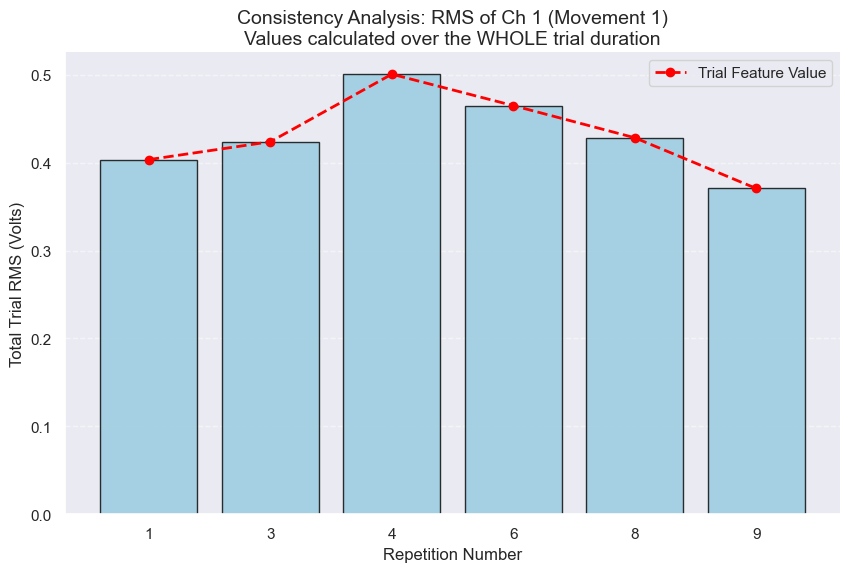

In [197]:
target_mov = 1          # Movement 1 (Index Flexion)
feature_idx = 1         # 1 = RMS (Root Mean Square)
feature_name = "RMS"
channel_idx = 0        # Channel 5 (Index 4)

plot_data = []

for rep_id in np.unique(rep_train_raw):
    mask = (y_train_raw == target_mov) & (rep_train_raw == rep_id)
    raw_segment = X_train_raw[mask]
    
    if len(raw_segment) > 0:
        feats = get_features_from_trial(raw_segment)
        
        col = (feature_idx * 10) + channel_idx
        val = feats[col]
        
        plot_data.append({
            'Repetition': str(int(rep_id)),
            'Feature Value': val
        })

df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='Repetition', y='Feature Value', 
            color='skyblue', edgecolor='black', alpha=0.8)

plt.plot(range(len(df)), df['Feature Value'], color='red', marker='o', 
         linestyle='--', linewidth=2, label='Trial Feature Value')

plt.title(f"Consistency Analysis: {feature_name} of Ch {channel_idx+1} (Movement {target_mov})\n"
          f"Values calculated over the WHOLE trial duration", fontsize=14)
plt.ylabel(f"Total Trial {feature_name} (Volts)", fontsize=12)
plt.xlabel("Repetition Number", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

plt.show()

## Support Vector Machine

Starting SVM Grid Search on 96 samples...
Fitting 1 folds for each of 12 candidates, totalling 12 fits
Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Validation Accuracy: 87.50%

FINAL TEST ACCURACY: 95.83%


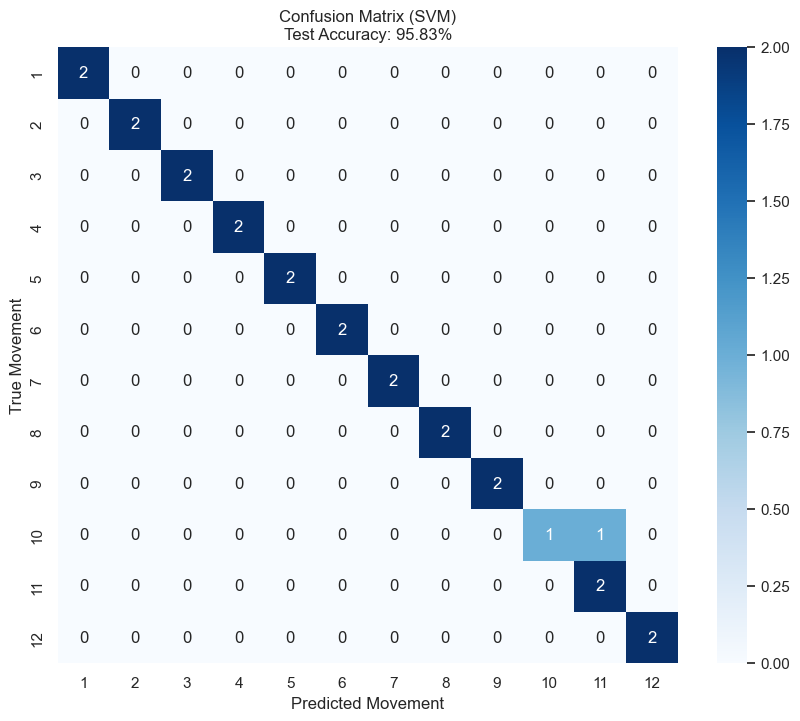

In [198]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.hstack((y_train, y_val))

test_fold = np.concatenate([
    np.full(X_train_scaled.shape[0], -1),
    np.full(X_val_scaled.shape[0], 0)
])
ps = PredefinedSplit(test_fold)

param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization (Model strictness)
    'gamma': ['scale', 0.01, 0.001], # Kernel coefficient (Influence radius)
    'kernel': ['rbf']                # Radial Basis Function (Standard for EMG)
}

print(f"Starting SVM Grid Search on {len(y_combined)} samples...")
grid = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=ps,               # Force use of our Val set
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid.fit(X_combined, y_combined)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Validation Accuracy: {grid.best_score_:.2%}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"\nFINAL TEST ACCURACY: {acc:.2%}")

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix (SVM)\nTest Accuracy: {acc:.2%}")
plt.xlabel("Predicted Movement")
plt.ylabel("True Movement")
plt.show()

# Part 2: Generalization across subjects

## Load data

In [236]:
for i in range(1,28):
    subject_id = 's' + str(i)
    load_and_save_raw_data(subject_id=subject_id, base_dir=EMG_DIR, output_dir=EMG_DIR)

Loading raw file: S1_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s1/s1_ex1_raw.npz
Loading raw file: S2_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz
Loading raw file: S3_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s3/s3_ex1_raw.npz
Loading raw file: S4_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s4/s4_ex1_raw.npz
Loading raw file: S5_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s5/s5_ex1_raw.npz
Loading raw file: S6_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s6/s6_ex1_raw.npz
Loading raw file: S7_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s7/s7_ex1_raw.npz
Loading raw file: S8_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s8/s8_ex1_raw.npz
Loading raw file: S9_A1_E1.mat
Saved raw data to /Users/bui/code/NX-421-project/data/EMG/s9/s9_ex1_raw.npz
Loading raw file: S10_A1_E1.mat
Saved

## Preprocessing data

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

In [237]:
for i in range(1, 28):
    s_num_lowercase = 's' + str(i)
    s_a1_e1_path = Path(EMG_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_raw.npz')
    output_path = Path(EMG_OUTPUT_DIR) / s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    os.makedirs(Path(EMG_OUTPUT_DIR) / s_num_lowercase, exist_ok=True)
    
    output_path = preprocess_emg_data(
        raw_npz_path=s_a1_e1_path,
        output_dir=EMG_OUTPUT_DIR,
    )
    
    print(f'Processed data saved to {output_path}')

Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s1/s1_ex1_processed.npz
Processed data saved to /Users/bui/code/NX-421-project/output/emg/s1/s1_ex1_processed.npz
Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz
Processed data saved to /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz
Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s3/s3_ex1_processed.npz
Processed data saved to /Users/bui/code/NX-421-project/output/emg/s3/s3_ex1_processed.npz
Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s4/s4_ex1_processed.npz
Processed data saved to /Users/bui/code/NX-421-project/output/emg/s4/s4_ex1_processed.npz
Processed (Filtered) data saved to /Users/bui/code/NX-421-project/output/emg/s5/s5_ex1_processed.npz
Processed data saved to /Users/bui/code/NX-421-project/output/emg/s5/s5_ex1_processed.npz
Processed (Filtered) data saved to /Users/bui

### Clean bad trials

In [242]:
for i in range(1,28):
    s_num_lowercase = 's' + str(i)
    input_path = Path(EMG_OUTPUT_DIR) /  s_num_lowercase / (s_num_lowercase + '_ex1_processed.npz')
    clean_and_filter_trials(input_path, output_dir=EMG_OUTPUT_DIR)

Filtering bad trials from /Users/bui/code/NX-421-project/output/emg/s1/s1_ex1_processed.npz
  Discarding Bad Trial: Mov 2, Rep 4 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 2, Rep 9 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 11, Rep 2 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 11, Rep 9 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 12, Rep 4 [Dead Channel(s):  [6]]
  Discarding Bad Trial: Mov 12, Rep 5 [Dead Channel(s):  [2]]
  Discarding Bad Trial: Mov 12, Rep 7 [Dead Channel(s):  [4]]
  Discarding Bad Trial: Mov 12, Rep 9 [Dead Channel(s):  [4]]
Original shape: (101014, 10)
Final shape:    (35540, 10) (Rest & Bad Trials removed)
Cleaned data saved to: /Users/bui/code/NX-421-project/output/emg/s1/s1_ex1_cleaned.npz
------------------------------
Filtering bad trials from /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz
Original shape: (100686, 10)
Final shape:    (41791, 10) (Rest & Bad Trials removed)
Cleaned data saved to: /Users/bui/

## Extract features

In [248]:
target_mov = 1           # Movement to analyze (e.g., 1 = Index Flexion)
feature_idx = 1          # 1 = RMS
feature_name = "RMS"
channel_idx = 0
all_subjects_data = []

print(f"Aggregating {feature_name} data for Movement {target_mov} across subjects...")

for i in range(1, 28):
    s_id = f's{i}'
    file_path = Path(EMG_OUTPUT_DIR) / s_id / f'{s_id}_ex1_cleaned.npz'
    
    if not file_path.exists():
        print(f"Skipping {s_id} because file doesn't exist")
        continue
        
    data = np.load(file_path, allow_pickle=True)
    X = data['emg']
    y = data['restimulus']
    rep = data['rerepetition']
    
    mask_mov = (y == target_mov)    
    available_reps = np.unique(rep[mask_mov])
    
    for r in available_reps:
        mask_trial = (y == target_mov) & (rep == r)
        trial_data = X[mask_trial]
        
        if len(trial_data) > 0:
            feats = get_features_from_trial(trial_data) # all features
            
            col_idx = (feature_idx * 10) + channel_idx
            val = feats[col_idx]
            
            all_subjects_data.append({
                'Subject': i,
                'Repetition': r,
                'Feature Value': val
            })

df_all = pd.DataFrame(all_subjects_data)
print(f"Loaded {len(df_all)} trials from {df_all['Subject'].nunique()} subjects.")

Aggregating RMS data for Movement 1 across subjects...
Loaded 262 trials from 27 subjects.


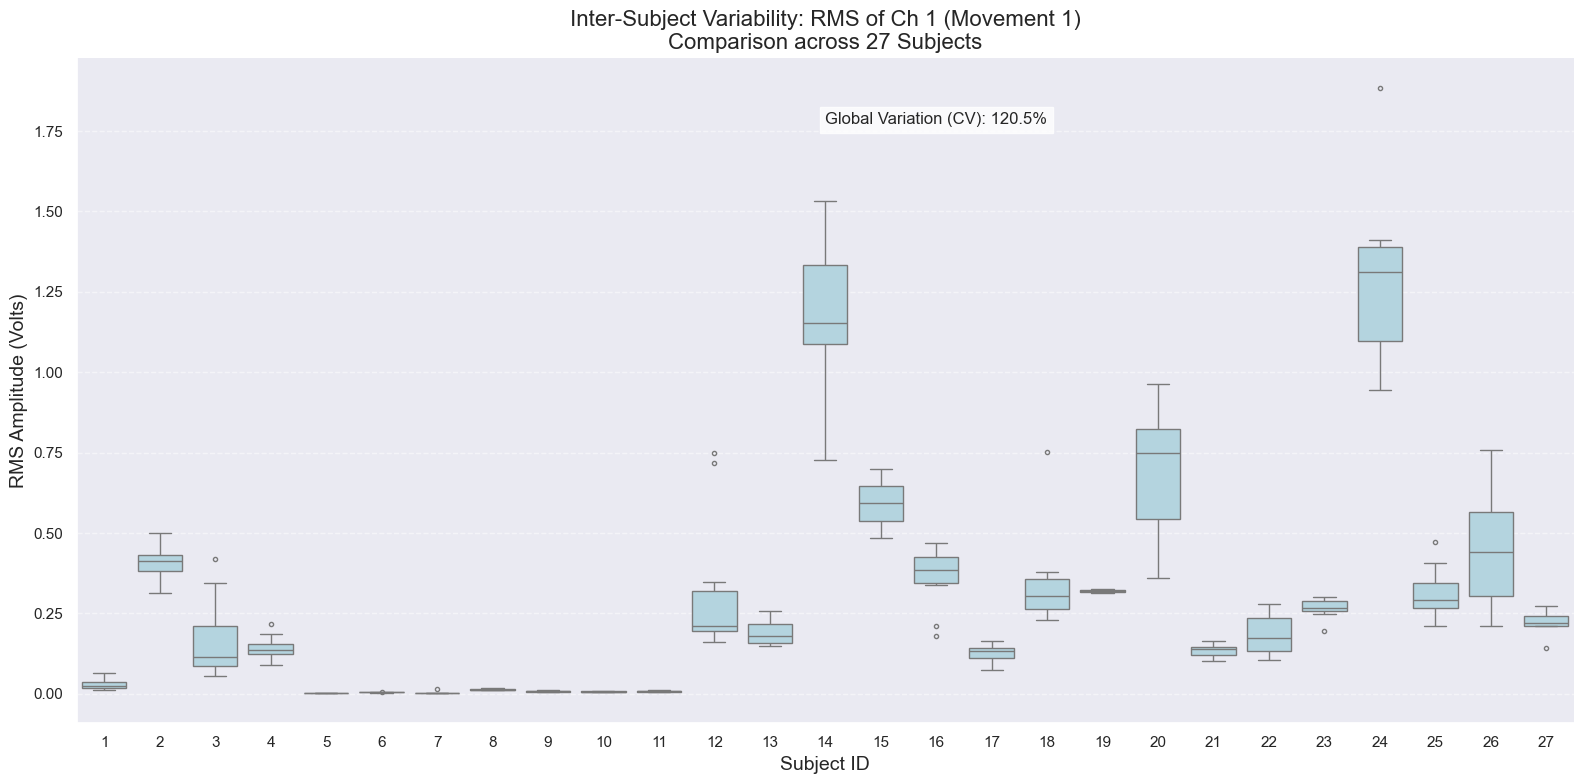

In [249]:
plt.figure(figsize=(16, 8))

sns.boxplot(data=df_all, x='Subject', y='Feature Value', 
            color='lightblue', fliersize=3, linewidth=1)

plt.title(f"Inter-Subject Variability: {feature_name} of Ch {channel_idx+1} (Movement {target_mov})\n"
          f"Comparison across {df_all['Subject'].nunique()} Subjects", fontsize=16)
plt.ylabel(f"{feature_name} Amplitude (Volts)", fontsize=14)
plt.xlabel("Subject ID", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Calculate Coefficient of Variation (CV) to quantify discrepancy
global_mean = df_all['Feature Value'].mean()
global_std = df_all['Feature Value'].std()
cv_pct = (global_std / global_mean) * 100

plt.text(0.5, 0.9, f"Global Variation (CV): {cv_pct:.1f}%", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

sns.despine()
plt.tight_layout()
plt.show()